# 1.
Для отчёта об эффективности рекламы «Королевства гномов» с 11 июля по 10 августа 2020 года вы уже рассчитали удержание, отскок, конверсию и «пожизненную ценность» пользователей.
Последняя важная метрика — ROI, возврат на инвестиции.
В дополнение к журналу сессий и данным о покупках дата-инженеры передали вам файл с рекламными расходами, ch02_problems02_costs.csv.
Его структура:

    channel — канал привлечения пользователей,
    costs — общие траты на рекламу с 11 июля по 10 августа 2020 года.

Для расчёта CAC и ROI не хватает разбивки рекламных расходов по дням. Учитывая, что траты распределялись по дням равномерно, приведите датасет к такой структуре:

    dt — дата привлечения пользователей,
    channel — канал привлечения,
    costs — средние траты на рекламу за день.

Подсказка
Получите доступ к каналам привлечения так: values['channel'].
Так же определите рекламные траты: values['costs'].
Чтобы найти средние траты за день, разделите рекламные траты (channel_costs) на количество дней в отчёте (days_num).
Рассчитайте текущую дату, прибавив к самой ранней дате в отчёте (min_date) количество дней до очередного дня из переменной i.
Последнее рассчитайте, вызвав функцию timedelta() и передав параметру days значение i.

In [2]:
import pandas as pd
from datetime import datetime, timedelta

visits = pd.read_csv('datasets/ch02_problems03_visits.csv')  # журнал сессий
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки
ad_costs = pd.read_csv('datasets/ch02_problems02_costs.csv')  # траты на рекламу

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

min_date =  datetime(2020, 7, 11)# добавьте самую раннюю дату в отчёте в формате datetime
max_date =  datetime(2020, 8, 10)# добавьте самую позднюю дату в отчёте в формате datetime

# находим количество дней в отчёте
days_num = (max_date - min_date).days

# создаём пустую таблицу для рекламных трат
daily_costs = []

# перебираем данные о затратах по источникам
for index, values in ad_costs.iterrows():

    channel_name =  values['channel']# определите канал привлечения
    channel_costs =  values['costs']# и общие рекламные траты на него
    avg_channel_costs =  channel_costs / days_num# рассчитайте средние траты за день

    # заполняем таблицу рекламных трат
    for i in range(days_num):
        current_day =  min_date + timedelta(i)# рассчитайте текущую дату
        # добавляем строку в таблицу трат
        daily_costs += [[current_day, channel_name, avg_channel_costs]]

# превращаем таблицу рекламных трат в датафрейм
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
# преобразуем данные о времени
daily_costs['dt'] = daily_costs['dt'].dt.date

print(daily_costs.head(5))

           dt    channel       costs
0  2020-07-11  BattleYes  487.736167
1  2020-07-12  BattleYes  487.736167
2  2020-07-13  BattleYes  487.736167
3  2020-07-14  BattleYes  487.736167
4  2020-07-15  BattleYes  487.736167


# 2.
В коде задана функция get_profiles(). Вызовите её, чтобы построить профили пользователей со стоимостью привлечения.
В качестве аргумента ad_costs передайте фрейм daily_costs, созданный на предыдущем шаге.

Подсказка
Вызовите функцию get_profiles(), передав ей такие аргументы: visits, purchases, events и daily_costs.

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np


def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
            .groupby('user_id')
            .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
            .rename(columns={'session_start': 'first_ts'})
            .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


visits = pd.read_csv('datasets/ch02_problems03_visits.csv')  # журнал сессий
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки
ad_costs = pd.read_csv('datasets/ch02_problems02_costs.csv')  # траты на рекламу
events = None  # других событий нет, None — чтобы не «сломать» get_profiles()

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

# разбиваем траты на рекламу по дням
min_date = datetime(2020, 7, 11)
max_date = datetime(2020, 8, 10)
days_num = (max_date - min_date).days

daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]

# создаём датафрейм с тратами на рекламу по дням
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

users =  get_profiles(sessions=visits, orders=purchases, events=events, ad_costs=daily_costs)# получите профили пользователей

print(users.head(5))

    user_id            first_ts     channel   device         region  \
0    242074 2020-08-05 06:04:32     Organic      Mac  United States   
1   4284686 2020-08-02 21:08:29  VaporStore   iPhone  United States   
2  10964006 2020-07-30 16:27:45     Organic  Android        Germany   
3  12358165 2020-07-26 02:06:13     Organic      Mac  United States   
4  12545358 2020-07-18 00:45:37     Organic       PC  United States   

           dt      month  payer  acquisition_cost  
0  2020-08-05 2020-08-01  False          0.000000  
1  2020-08-02 2020-08-01  False          2.347259  
2  2020-07-30 2020-07-01  False          0.000000  
3  2020-07-26 2020-07-01  False          0.000000  
4  2020-07-18 2020-07-01  False          0.000000  


# 3.
В коде задана функция get_ltv().
Вызовите её, чтобы рассчитать LTV и ROI с разбивкой по каналам привлечения.
Момент анализа — 10 августа 2020 года, горизонт — неделя.
Чтобы построить кривые ROI, исключите размеры когорт и CAC из таблицы ROI.
Оставшаяся часть кода уже написана.

Подсказка
Вызовите get_ltv(), передав ей фреймы users и purchases, момент и горизонт анализа данных, а также параметр dimensions.
Момент анализа получите так: datetime(2020, 8, 10).date().
В качестве горизонта анализа передайте значение 7.
Параметру dimensions передайте список с названием столбца для группировки — 'channel'.

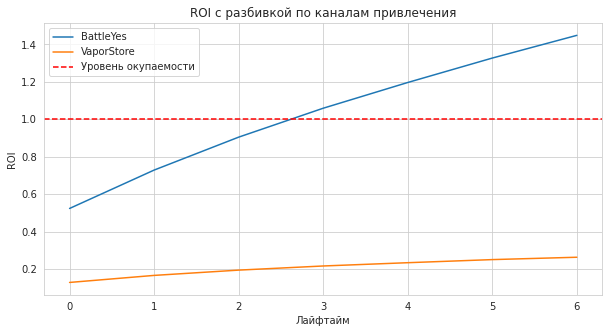

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


# функция для получения пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
            .groupby('user_id')
            .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
            .rename(columns={'session_start': 'first_ts'})
            .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


# функция для расчёта LTV и ROI
def get_ltv(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
                .agg({'acquisition_cost': 'mean'})
                .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


visits = pd.read_csv('datasets/ch02_problems03_visits.csv')  # журнал сессий
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки
ad_costs = pd.read_csv('datasets/ch02_problems02_costs.csv')  # траты на рекламу
events = None  # других событий нет

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

# разбиваем траты на рекламу по дням
min_date = datetime(2020, 7, 11)
max_date = datetime(2020, 8, 10)
days_num = (max_date - min_date).days
daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

users = get_profiles(visits, purchases, events, daily_costs)  # профили с CAC

# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles=users,
                                                      purchases=purchases,
                                                      observation_date=datetime(2020, 8, 10).date(),
                                                      horizon_days=7,
                                                      dimensions=['channel'])
# исключите размеры когорт и CAC из таблицы ROI
report = roi.drop(columns=['cohort_size', 'cac'])
# строим кривые ROI
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()